In [1]:
#fetch GFS data and plot at ENA
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import netCDF4
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from datetime import datetime, timedelta
from netCDF4 import num2date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import tempfile
import os
import boto3

%matplotlib inline


In [151]:
import imp
lib_loc = os.path.join(os.path.expanduser('~'), 'projects/ACE-ENA-EVA/code/ena_tools.py')
ena_tools = imp.load_source('ena_tools', lib_loc)


/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [123]:
my_ncss = ena_tools.give_me_gfs()

AttributeError: module 'ena_tools' has no attribute 'give_me_gfs'

In [27]:
query = my_ncss.query()
now = datetime.utcnow()
gra_lat = 39.0525
gra_lon = -28.0069
query.lonlat_point(gra_lon, gra_lat).all_times()

temporal=all&longitude=-28.0069&latitude=39.0525

In [28]:
query = my_ncss.query()
now = datetime.utcnow()
gra_lat = 39.0525
gra_lon = -28.0069
query.lonlat_point(gra_lon, gra_lat).time(now)
query.variables('all').accept('netcdf')
data = ncss.get_data(query)
list(data.variables.keys())


NameError: name 'ncss' is not defined

In [33]:
my_ncss = ena_tools.give_me_gfs()
my_ts = ena_tools.get_me_grw_ts(my_ncss, ['Temperature_height_above_ground',
               'Dewpoint_temperature_height_above_ground'])

In [15]:
list(my_ts.variables.keys())

['height_above_ground',
 'Dewpoint_temperature_height_above_ground',
 'height_above_ground4',
 'Temperature_height_above_ground',
 'station_name',
 'station_description',
 'latitude',
 'longitude',
 'time']

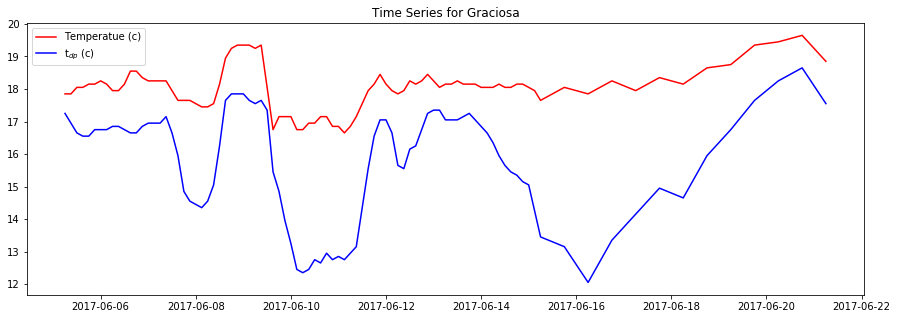

In [34]:
temp = my_ts.variables['Temperature_height_above_ground']
dp = my_ts.variables['Dewpoint_temperature_height_above_ground']
time = my_ts.variables['time']
datetimes = num2date(time[:].squeeze(), time.units)
fig = plt.figure(figsize = [15,5])
plt.plot(datetimes, temp[:].squeeze()-273.15, 'r-', label='Temperatue (c)')
plt.plot(datetimes, dp[:].squeeze()-273.15, 'b-', label=r't$_{dp}$ (c)')
plt.legend()
plt.title('Time Series for Graciosa')


In [35]:
s3_key = ena_tools.gen_s3_key(datetimes[0], 'T_ts_timeseries_GFS_GRW')

In [36]:
s3_key

'2017/06/05/T_ts_timeseries_GFS_GRW20170605_0600.png'

In [37]:
local_fig =  tempfile.NamedTemporaryFile(suffix='.png')
fn = local_fig.name
fig_datetime = ena_tools.plot_ttd_gra(my_ts, fn)
s3_key = ena_tools.gen_s3_key(fig_datetime, 'T_ts_timeseries_GFS_GRW')
s3 = boto3.resource('s3')
data = open(fn, 'rb')
s3.Bucket('aceena').put_object(Key=s3_key, Body=data, ACL='public-read')
data.close()
 

In [13]:
print(now)

2017-06-02 22:15:38.714663


In [108]:
def add_panel(data_set,time_step, 
              times, fig, ax, bbox,
             background_var = 'Temperature_surface',
             oset = -273.15, scale = 1., 
             pref = u'SFC T forecast (\u00b0C)', 
             vmin = 15, vmax = 25):
    gra_lat = 39.0525
    gra_lon = -28.0069
    ter_lat = 38.7216
    ter_lon = -27.2206
    north = bbox[3]
    south = bbox[2]
    west = bbox[1]
    east = bbox[0]
    lat_vals = data_set.variables['lat'][:].squeeze()
    lon_vals = data_set.variables['lon'][:].squeeze()
    lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)

    # Add the map and set the extent
    ax.set_xticks(np.arange(west, east, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(south, north, 5), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    print(bbox)
    

    # Add state boundaries to plot
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                                facecolor='none', name='coastline')
    _ = ax.add_feature(coast, edgecolor='black')


    # Contour temperature at each lat/long
    cf = ax.pcolormesh(lon_2d, lat_2d, scale * data_set[background_var][time_step] + oset, 
                                       transform=ccrs.PlateCarree(), 
                                       zorder=0,
                                       cmap='coolwarm', vmin=vmin, vmax=vmax)

    cn = ax.contour(lon_2d, lat_2d, 
                    data_set['MSLP_Eta_model_reduction_msl'][time_step]/100.0, 
                    np.arange(980, 1040, 2), colors='black')

    plt.clabel(cn, inline=1, fontsize=10, fmt='%1.0f')
    ax.set_extent(bbox)


    # Plot a colorbar to show temperature and reduce the size of it
    plt.colorbar(cf, ax=ax, fraction=0.032)

    # Make a title with the time value
    time_val = times[time_step]
    ax.set_title(pref + ' for {0:%d %B %Y %H:%MZ}'.format(time_val),
                 fontsize=10)


    ax.plot([ter_lon, gra_lon], [ter_lat, gra_lat],
           'ro', transform=ccrs.PlateCarree())

    ax.text(ter_lon+.2, ter_lat+.2, 
            'Tericia', transform=ccrs.PlateCarree(), fontsize = 10)

    ax.text(gra_lon+.2, gra_lat+.2, 
            'Graciosa', transform=ccrs.PlateCarree(), fontsize = 10)
    


In [4]:
my_ncss = ena_tools.give_me_latest_gfs()

In [111]:
bbox = [-5, -35, 30, 50]
north = bbox[3]
south = bbox[2]
west = bbox[1]
east = bbox[0]

query = my_ncss.query()
query.lonlat_box(north=north, south=south, 
                 east=east, west=west).vertical_level(0).all_times()
query.accept('netcdf4')
query.variables('Temperature_surface', 
                'MSLP_Eta_model_reduction_msl',
               'Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average')
data = my_ncss.get_data(query)


In [112]:
time = data.variables['time1']
datetimes = num2date(time[:].squeeze(), time.units)
time_steps = [0,2,4,6,8,10,12,14,16]

In [104]:
print(data.variables['lon'][:].min())

325.0


[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]


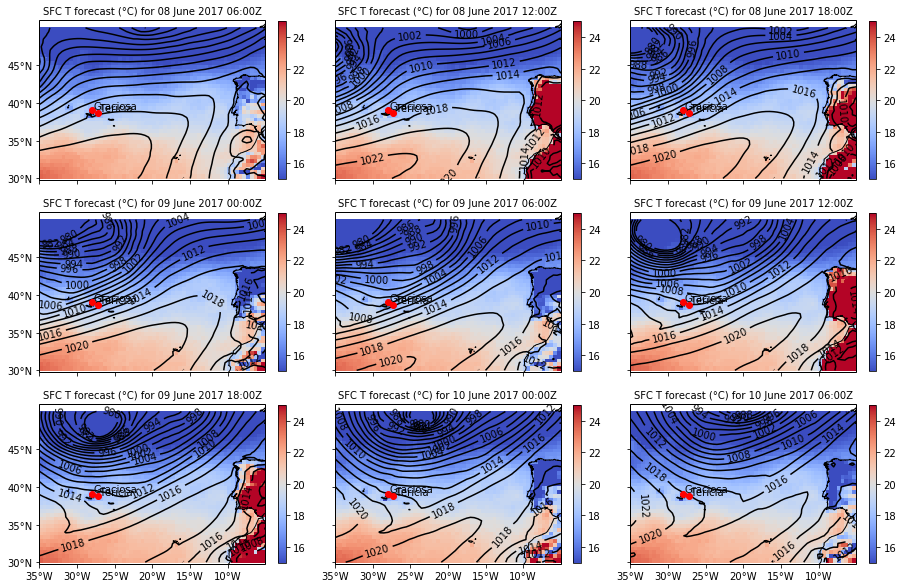

In [109]:
f, ((ax1, ax2, ax3), 
    (ax4, ax5, ax6), 
    (ax7, ax8, ax9)) = plt.subplots(3,3, figsize = [15,10],
                                    sharex=True, sharey=True,
                                    subplot_kw={'projection': ccrs.PlateCarree()})

axxx = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
for i in range(len(axxx)):
    add_panel(data,time_steps[i], datetimes, f, axxx[i], bbox)

plt.savefig('/Users/scollis/panels.png')

[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]


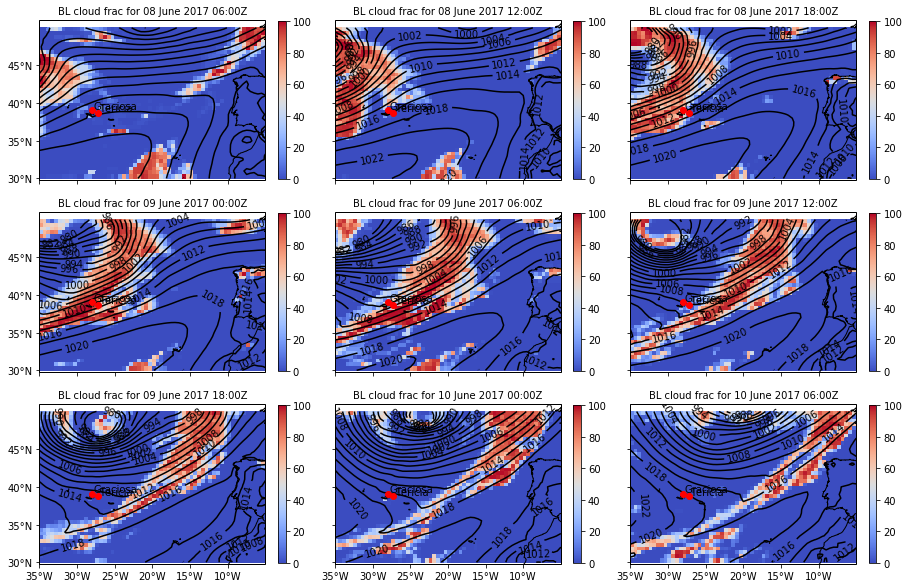

In [115]:
f, ((ax1, ax2, ax3), 
    (ax4, ax5, ax6), 
    (ax7, ax8, ax9)) = plt.subplots(3,3, figsize = [15,10],
                                    sharex=True, sharey=True,
                                    subplot_kw={'projection': ccrs.PlateCarree()})

axxx = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
for i in range(len(axxx)):
    add_panel(data,time_steps[i], datetimes, f, axxx[i], bbox,
             background_var='Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average',
             vmin=0, vmax=100, oset=0, pref='BL cloud frac')

plt.savefig('/Users/scollis/panels2.png')

In [76]:
def add_panel(data_set,time_step, 
              times, fig, ax, bbox,
             background_var = 'Temperature_surface',
             oset = -273.15, scale = 1., 
             pref = u'SFC T forecast (\u00b0C)', 
             vmin = 15, vmax = 25):


(93, 27, 53)

[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]


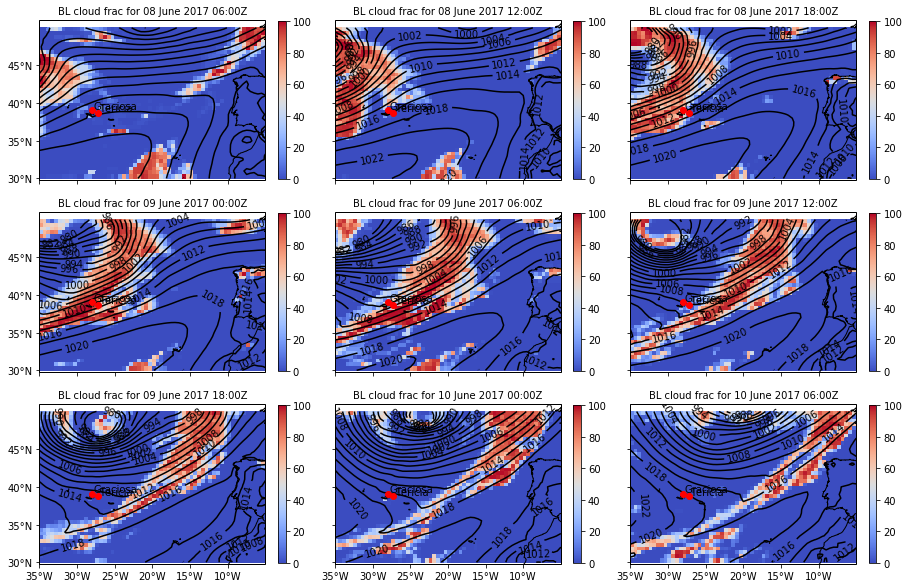

In [119]:
bbox = [-5, -35, 30, 50]
my_v = ['Temperature_surface', 
        'MSLP_Eta_model_reduction_msl',
        'Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average']
my_ncss = ena_tools.give_me_latest_gfs()
my_data = ena_tools.get_sfc_gfs(my_ncss, my_v, bbox)

f, ((ax1, ax2, ax3), 
    (ax4, ax5, ax6), 
    (ax7, ax8, ax9)) = plt.subplots(3,3, figsize = [15,10],
                                    sharex=True, sharey=True,
                                    subplot_kw={'projection': ccrs.PlateCarree()})

time = my_data.variables['time1']
datetimes = num2date(time[:].squeeze(), time.units)
time_steps = [0,2,4,6,8,10,12,14,16]
axxx = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
for i in range(len(axxx)):
    add_panel(my_data,time_steps[i], datetimes, f, axxx[i], bbox,
             background_var='Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average',
             vmin=0, vmax=100, oset=0, pref='BL cloud frac')

plt.savefig('/Users/scollis/panels2.png')

['Temperature_surface', 'Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average', 'Planetary_Boundary_Layer_Height_surface', 'Precipitation_rate_surface_Mixed_intervals_Average', 'MSLP_Eta_model_reduction_msl']
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]
[-5, -35, 30, 50]


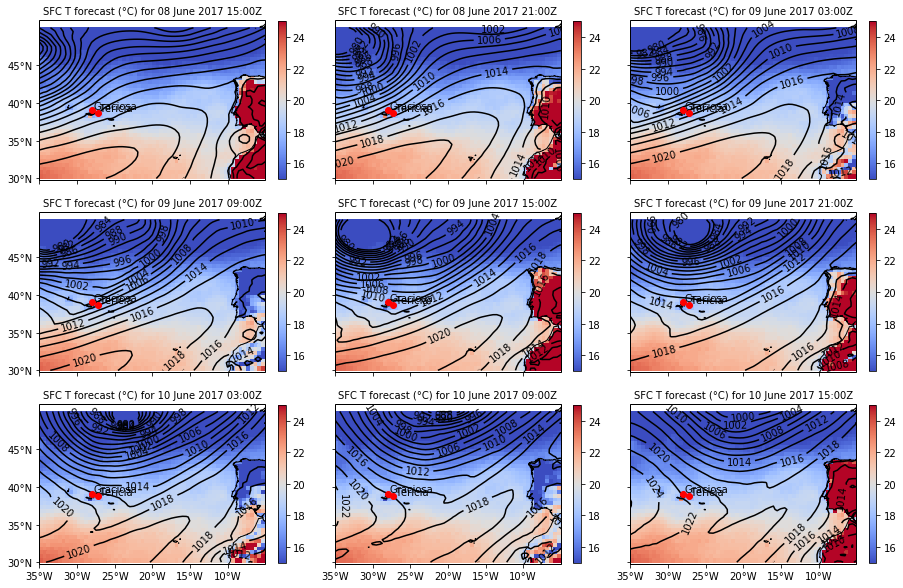

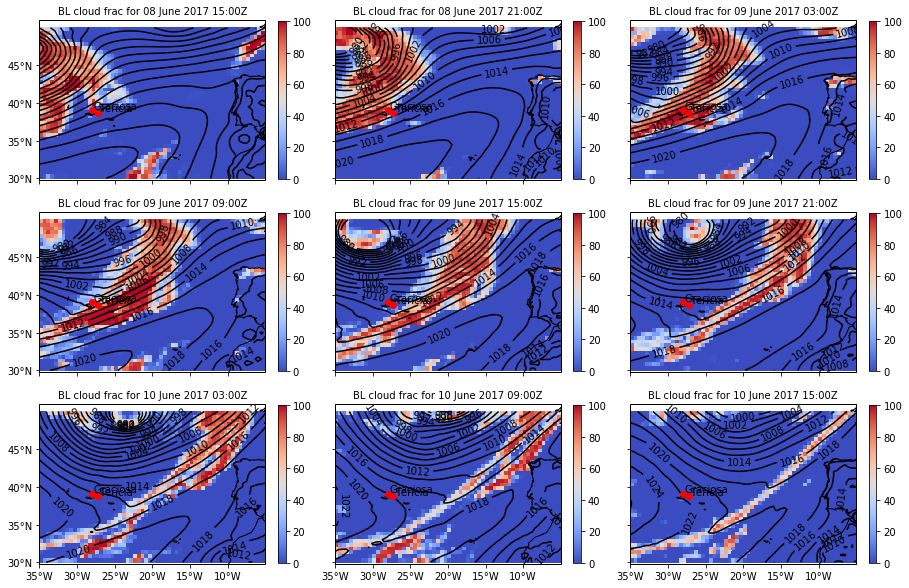

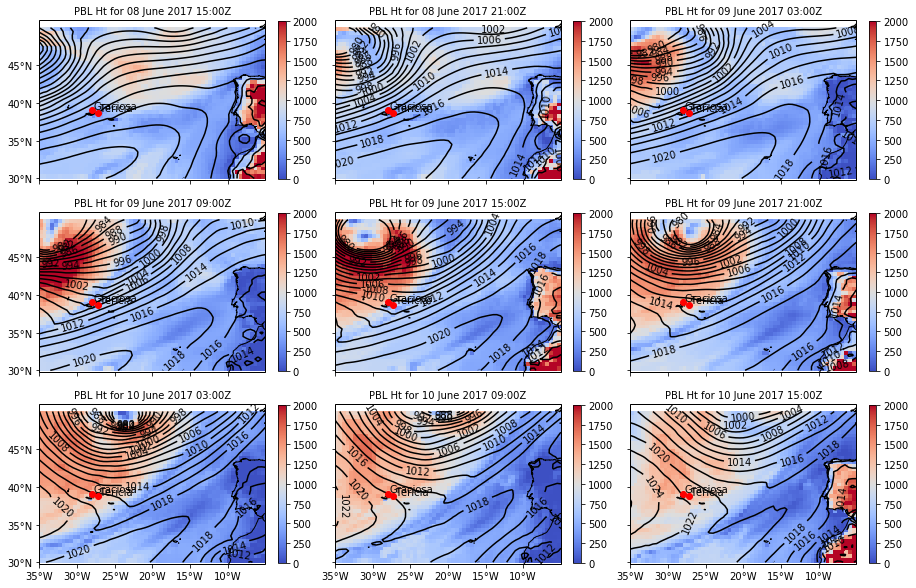

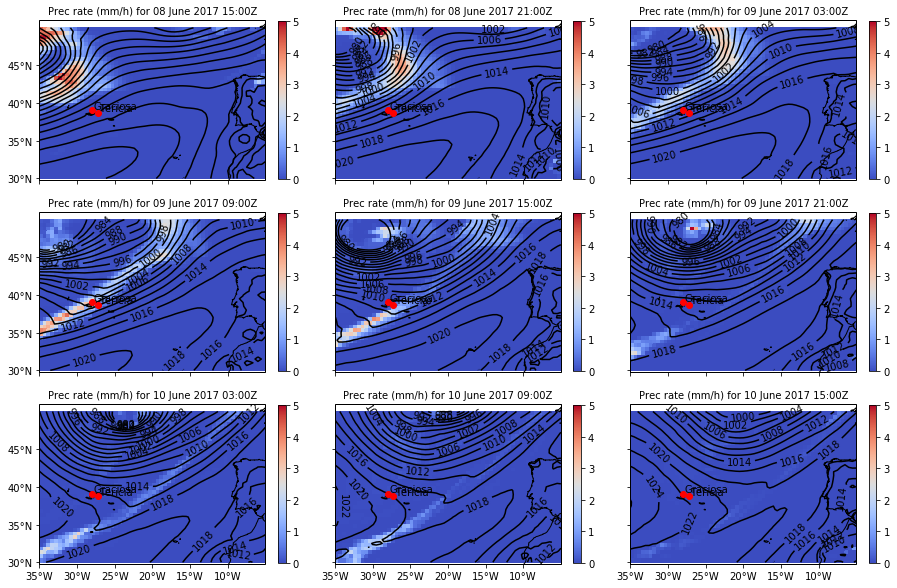

In [152]:
bbox = [-5, -35, 30, 50]
varrs = ['Temperature_surface',
       'Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average',
        'Planetary_Boundary_Layer_Height_surface',
        'Precipitation_rate_surface_Mixed_intervals_Average']
names = ['temp_nine_panel_gfs', 'BL_clouds_nine_panel_gfs', 'PBL_H', 'precip']
mins = [15, 0, 0, 0, 0]
maxs = [25, 100, 2000, 5]
osets = [-273.15, 0, 0, 0]
scales = [1. , 1., 1., 60.*60.]
prefs = [ u'SFC T forecast (\u00b0C)', 'BL cloud frac', 'PBL Ht', 'Prec rate (mm/h)']
varrs.append('MSLP_Eta_model_reduction_msl')
print(varrs)
my_ncss = ena_tools.give_me_latest_gfs()
my_data = ena_tools.get_sfc_gfs(my_ncss, varrs, bbox)
time_steps = [0,2,4,6,8,10,12,14,16]
local_fig =  tempfile.NamedTemporaryFile(suffix='.png')
fn = local_fig.name
for i in range(len(names)):
    fig_datetime = ena_tools.nine_panel(my_data, bbox, time_steps, 
                                    bgv=varrs[i],
                                    vmin=mins[i], vmax=maxs[i], oset=osets[i],
                                    scale=scales[i], pref=prefs[i])
    plt.savefig(fn)
    ena_tools.save_one_9pan(names[i], fn, fig_datetime)


In [150]:
my_data.variables['Precipitation_rate_surface_Mixed_intervals_Average'].units

'kg.m-2.s-1'